Lambda School Data Science

*Unit 2, Sprint 2, Module 4*

---

In [2]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/main/data/'
    !pip install category_encoders==2.*
    !pip install pandas-profiling==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

# Module Project: Classification Metrics

This sprint, the module projects will focus on creating and improving a model for the Tanazania Water Pump dataset. Your goal is to create a model to predict whether a water pump is functional, non-functional, or needs repair.

Dataset source: [DrivenData.org](https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/).

## Directions

The tasks for this project are as follows:

- **Task 1:** Use `wrangle` function to import training and test data.
- **Task 2:** Split training data into feature matrix `X` and target vector `y`.
- **Task 3:** Split training data into training and validation sets.
- **Task 4:** Establish the baseline accuracy score for your dataset.
- **Task 5:** Build `model`.
- **Task 6:** Calculate the training and validation accuracy score for your model.
- **Task 7:** Plot the confusion matrix for your model.
- **Task 8:** Print the classification report for your model.
- **Task 9:** Identify likely `'non-functional'` pumps in the test set.
- **Task 10:** Find likely `'non-functional'` pumps serving biggest populations.
- **Task 11 (`stretch goal`):** Plot pump locations from Task 10.

You should limit yourself to the following libraries for this project:

- `category_encoders`
- `matplotlib`
- `pandas`
- `pandas-profiling`
- `plotly`
- `sklearn`


# I. Wrangle Data

In [4]:
def wrangle(fm_path, tv_path=None):
    if tv_path:
        df = pd.merge(pd.read_csv(fm_path, 
                                  na_values=[0, -2.000000e-08]),
                      pd.read_csv(tv_path)).set_index('id')
    else:
        df = pd.read_csv(fm_path, 
                         na_values=[0, -2.000000e-08],
                         index_col='id')

    # Drop constant columns
    df.drop(columns=['recorded_by'], inplace=True)

    # Drop HCCCs
    cutoff = 100
    drop_cols = [col for col in df.select_dtypes('object').columns
                 if df[col].nunique() > cutoff]
    df.drop(columns=drop_cols, inplace=True)

    # Drop duplicate columns
    dupe_cols = [col for col in df.head(15).T.duplicated().index
                 if df.head(15).T.duplicated()[col]]
    df.drop(columns=dupe_cols, inplace=True)             

    return df

**Task 1:** Using the above `wrangle` function to read `train_features.csv` and `train_labels.csv` into the DataFrame `df`, and `test_features.csv` into the DataFrame `X_test`.

In [6]:
import pandas as pd

df = wrangle('../data/waterpumps/train_features.csv', '../data/waterpumps/train_labels.csv')
X_test = wrangle('../data/waterpumps/test_features.csv')

# II. Split Data

**Task 2:** Split your DataFrame `df` into a feature matrix `X` and the target vector `y`. You want to predict `'status_group'`.

**Note:** You won't need to do a train-test split because you'll use cross-validation instead.

In [53]:
target = 'status_group'
X = df.drop(columns=target)
y = df[target]

**Task 3:** Using a randomized split, divide `X` and `y` into a training set (`X_train`, `y_train`) and a validation set (`X_val`, `y_val`).

In [54]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# III. Establish Baseline

**Task 4:** Since this is a **classification** problem, you should establish a baseline accuracy score. Figure out what is the majority class in `y_train` and what percentage of your training observations it represents.

In [55]:
baseline_acc = y_train.value_counts(normalize=True).max()
print('Baseline Accuracy Score:', baseline_acc)

Baseline Accuracy Score: 0.5425829668132747


# IV. Build Models

**Task 5:** Build and train your `model`. Include the transformers and predictor that you think are most appropriate for this problem.

In [56]:
from category_encoders import OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline

model = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier(
        n_estimators=50,
        n_jobs=-1,
        random_state=42
    )
)
model.fit(X_train, y_train)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['basin', 'region', 'public_meeting',
                                      'scheme_management', 'permit',
                                      'extraction_type',
                                      'extraction_type_class', 'management',
                                      'management_group', 'payment',
                                      'payment_type', 'water_quality',
                                      'quality_group', 'quantity', 'source',
                                      'source_type', 'source_class',
                                      'waterpoint_type',
                                      'waterpoint_type_group'],
                                mapping=[...
communal standpipe multiple    4
improved spring                5
cattle trough                  6
dam                            7
NaN                           -2
dtype: int64},
                                         {'col': 'water

# V. Check Metrics

**Task 6:** Calculate the training and validation accuracy scores for `model`.

In [57]:
training_acc = model.score(X_train, y_train)
val_acc = model.score(X_val, y_val)

print('Training Accuracy Score:', training_acc)
print('Validation Accuracy Score:', val_acc)

Training Accuracy Score: 0.9944864159599318
Validation Accuracy Score: 0.8063131313131313


**Task 7:** Plot the confusion matrix for your model, using your validation data.

**Note:** Since there are three classes in your target vector, the dimensions of your matrix will be 3x3.

C:\Users\jeffkang\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


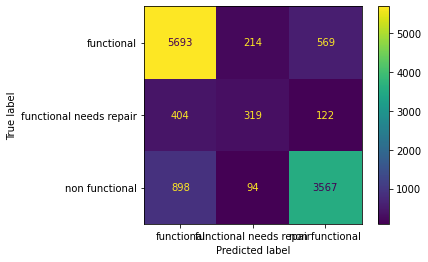

In [58]:
from sklearn.metrics import plot_confusion_matrix, classification_report
# Plot 3x3 confusion matrix
plot_confusion_matrix(
    model,
    X_val,
    y_val,
    values_format='.0f'
)

Calculating precision and recall for a multiclass problem is a bit of a mess. Fortunately, we can use `sklearn`'s classification report.

**Task 8:**  Print the classification report for your `model`, using your validation data.

In [59]:
# Print classification report 
print(classification_report(y_val, model.predict(X_val)))

                         precision    recall  f1-score   support

             functional       0.81      0.88      0.85      6476
functional needs repair       0.51      0.38      0.43       845
         non functional       0.84      0.78      0.81      4559

               accuracy                           0.81     11880
              macro avg       0.72      0.68      0.70     11880
           weighted avg       0.80      0.81      0.80     11880



# VI. Tune Model

Usually, we use this part of the ML workflow to adjust the hyperparameters of the our model to increase performance based on metrics like accuracy. Today, we'll use it to help maximize the impact of our water pump repairs when resources are scarce. What if we only had funds to repair 100 water pumps?

(This activity is based on a [post](https://towardsdatascience.com/maximizing-scarce-maintenance-resources-with-data-8f3491133050) by Lambda alum Michael Brady.)

**Task 9:** Using your model's `predict_proba` method, identify the observations in your **test set** where the model is more than 95% certain that a pump is `'non-functional'`. Put these observations in the DataFrame `X_test_nf`.

In [60]:
data = {'y_val': y_val, 'y_pred_proba': model.predict_proba(X_val)[:,-1]}
X_test_nf = pd.DataFrame(data)
display(X_test_nf)
print(X_test_nf.shape)

,y_val,y_pred_proba
id,,
37098.0,non functional,1.00
14530.0,functional,0.30
71755.0,functional,0.00
55610.0,functional,0.00
19821.0,functional,0.00
...,...,...
50523.0,functional,0.00
73846.0,functional,0.00
42110.0,functional,0.00


(11880, 2)


**Task 10:** Limit `X_test_nf` to the 100 pumps with the largest associated populations.

In [70]:
n_inspections = 100
threshold = 0.95
mask = X_test_nf['y_pred_proba'] > threshold

X_val['y_pred_proba'] = mask
X_val = X_val.sort_values(by=['population'], ascending=False)

print(X_val.shape)
X_val_pred = X_val[X_val['y_pred_proba'] == True]
X_test_nf = X_val_pred.head(100)
print(X_test_nf.shape)
display(X_test_nf.head())

(11880, 29)
(100, 29)


,amount_tsh,gps_height,longitude,latitude,num_private,basin,region,region_code,district_code,population,...,payment_type,water_quality,quality_group,quantity,source,source_type,source_class,waterpoint_type,waterpoint_type_group,y_pred_proba
id,,,,,,,,,,,,,,,,,,,,,
5507.0,NaN,1075.0,31.037232,-5.109649,NaN,Lake Tanganyika,Kigoma,16,3.0,6000.0,...,unknown,soft,good,enough,shallow well,shallow well,groundwater,other,other,True
41811.0,10.0,1831.0,31.628625,-7.982393,NaN,Lake Tanganyika,Rukwa,15,4.0,5030.0,...,per bucket,soft,good,dry,river,river/lake,surface,communal standpipe,communal standpipe,True
35975.0,NaN,338.0,38.802949,-10.572394,NaN,Ruvuma / Southern Coast,Mtwara,90,33.0,5000.0,...,never pay,soft,good,dry,shallow well,shallow well,groundwater,other,other,True
74047.0,NaN,817.0,29.652188,-4.847905,NaN,Lake Tanganyika,Kigoma,16,4.0,4145.0,...,never pay,soft,good,dry,lake,river/lake,surface,communal standpipe,communal standpipe,True
8422.0,6000.0,1430.0,35.599698,-7.800113,NaN,Rufiji,Iringa,11,1.0,2800.0,...,annually,soft,good,dry,spring,spring,groundwater,communal standpipe,communal standpipe,True


# VII. Communicate Results

**Task 11 (`stretch goal`):** Create a scatter plot with the location of the 100 pumps in `X_test_nf`.

**Note:** If you want to make this a **`super stretch goal`**, create a Mapbox scatter plot using [Plotly](https://plotly.github.io/plotly.py-docs/generated/plotly.express.scatter_mapbox.html).